# 13. Aprendizaje por Refuerzo - Deep Q-Learning - Lunar Lander

Vamos a entrenar un agente para que aprenda a aterrizar el módulo lunar.

<img src="./images/lunar_lander.gif" width = 60% >

## Preparación del entorno

In [1]:
import time
from collections import deque, namedtuple

import gym              # Colección de entornos de prueba para algoritmos de aprendizaje por refuerzo `pip install gym`
import numpy as np
import PIL.Image        # Para visualizar el entorno y los resultados
import tensorflow as tf
import utils_A1

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam



In [4]:
# Hyperparameters
MEMORY_SIZE = 100_000     # size of memory buffer.
GAMMA = 0.995             # discount factor.
ALPHA = 1e-3              # learning rate.
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps.

## Lunar Lander Environment

[OpenAI's Gym Library](https://www.gymlibrary.dev/) proporciona un conjunto de entornos preparados para aprendizaje por refuerzo.
Un 'entorno' representa un problema o tarea a resolver, e incluye la definición del 'mundo' en el que se desarrolla la tarea, las acciones que puede realizar el agente, y la forma en que se evalúa la tarea.

En este caso, vamos a utilizar el entorno [Lunar Lander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) de la librería Box2D de OpenAI Gym.

El objetivo del entorno Lunar Lander es aterrizar el módulo lunar de forma segura en la plataforma de aterrizaje en la superficie de la luna. La plataforma de aterrizaje está designada por dos banderines y siempre está en las coordenadas `(0,0)`, pero el módulo lunar también puede aterrizar fuera de la plataforma de aterrizaje. El módulo lunar comienza en la parte superior central del entorno con una fuerza inicial aleatoria aplicada a su centro de masa y tiene combustible infinito. El entorno se considera resuelto si obtienes `200` puntos.


<br>
<img src = "images/lunar_lander.gif" width = 40%>


### 1. Action Space

En cada paso de tiempo, el agente puede realizar una de las siguientes acciones:

* No hacer nada.
* Encender el motor derecho.
* Encender el motor principal.
* Encender el motor izquierdo.

Cada acción tiene un valor numérico correspondiente:

```python
No hacer nada = 0
Encender motor derecho = 1
Encender motor principal = 2
Encender motor izquierdo = 3
```

### 2 Observation Space

El agente recibe información sobre el estado del entorno en cada paso de tiempo. El espacio de observación del agente consta de un vector de estado con 8 variables:

* Coordenadas $(x,y)$.
* Velocidades lineales $(\dot x,\dot y)$.
* Ángulo $\theta$.
* Velocidad angular $\dot \theta$.
* Dos booleanos, $l$ y $r$, que representan si cada pierna está en contacto con el suelo o no.


### 3 Rewards

El entorno Lunar Lander tiene el siguiente sistema de recompensas:

* Aterrizar en la plataforma de aterrizaje y detenerse es de unos 100-140 puntos.
* Si el módulo lunar se aleja de la plataforma de aterrizaje, pierde recompensa.
* Si el módulo lunar se estrella, recibe -100 puntos.
* Si el módulo lunar se detiene, recibe +100 puntos.
* Cada pierna con contacto con el suelo es +10 puntos.
* Encender el motor principal es -0.3 puntos por cada fotograma.
* Encender el motor lateral es -0.03 puntos por cada fotograma.


### 4 Episode Termination

Un episodio termina (es decir, el entorno entra en un estado terminal) si:

* El módulo lunar se estrella (es decir, si el cuerpo del módulo lunar entra en contacto con la superficie de la luna).
* El valor absoluto de la coordenada $x$ del módulo lunar es mayor que 1 (es decir, va más allá del borde izquierdo o derecho).

Se puede revisar la documentación completa del entorno en [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/). 

## Preparamos el entorno

Este se carga con la función `make` de la librería `gym`. Tras cargarlo, es buena idea usar la función `reset` para inicializar el entorno y obtener la primera observación.

In [6]:
env = gym.make('LunarLander-v2', render_mode="human")

In [7]:
env.reset()

(array([-0.00552187,  1.3984284 , -0.55931914, -0.5552006 ,  0.00640524,
         0.12669422,  0.        ,  0.        ], dtype=float32),
 {})

Vamos a resolver el problema utilizando una red neuronal, para lo que necesitamos conocer el tamaño del vector de estado y el número de acciones válidas. Podemos obtener esta información de nuestro entorno utilizando los métodos `.observation_space.shape` y `action_space.n`, respectivamente.


In [97]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


El paquete gym define la estructura básica del aprendizaje por refuerzo:

<br>
<img src = "images/rl_formalism.png" width = 40%>

En un loop de aprendizaje por refuerzo estándar, un agente interactúa con el entorno en pasos discretos de tiempo $t=0,1,2,...$. En cada paso de tiempo $t$, el agente utiliza una política $\pi$ para seleccionar una acción $A_t$ basada en su observación del estado $S_t$ del entorno. El agente recibe una recompensa numérica $R_t$ y en el siguiente paso de tiempo, se mueve a un nuevo estado $S_{t+1}$.

En los entornos definidos con el paquete Gym se usa la función `.step()` para avanzar un paso (ejecutar un ciclo) en la dinámica del entorno, en nuestro caso, esto equivale a aplicar la acción que se escoja y a actualizar las siguietnes variables que se definen en el entorno:

* `observation` (**object**): es una clase específica del entrono, en el módulo lunar, corresponde con un array numpy con el "observation space" definido antes.

* `reward` (**float**): recompensa resultado de tomar una acción.

* `done` (**boolean**): indica que el episodio a terminado (`True`) o no.

* `truncated` (**boolean**): indica que el episodio se ha truncado (`True`) o no.

* `info` (**dictionary**): información adicional que puede ser útil para depurar el entorno.

In [98]:
# Reset the environment and get the initial state.
initial_state = env.reset()

Con el entorno en el punto de origen, podem empezar a realizar acciones usando el método `.step()`, el agente realiza una acción por paso de tiempo.

```python
No hacer nada = 0
Encender motor derecho = 1
Encender motor principal = 2
Encender motor izquierdo = 3
```

In [8]:
# Select an action.
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _, _ = env.step(action)

# Display table with values. All values are displayed to 3 decimal places.
env.render()

c:\Users\icira\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [11]:
env.reset()

for i in range(40):
    next_state, reward, done, _, _ = env.step(0)
    env.render()
    time.sleep(0.1)

for i in range(30):
    next_state, reward, done, _, _ = env.step(2)
    env.render()
    time.sleep(0.1)

for i in range(30):
    next_state, reward, done, _, _ = env.step(3)
    env.render()
    time.sleep(0.1)

## Deep Q-Learning

En los casos en que tanto el espacio de estados como el de acciones son discretos, podemos estimar la función de valor de acción de forma iterativa utilizando la ecuación de Bellman:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

Este método iterativo converge a la función de valor de acción óptima $Q^*(s,a)$ cuando $i\to\infty$. Esto significa que el agente solo necesita explorar gradualmente el espacio de estados y acciones y seguir actualizando la estimación de $Q(s,a)$ hasta que converja a la función de valor de acción óptima $Q^*(s,a)$. Sin embargo, en los casos en que el espacio de estados es continuo, se vuelve prácticamente imposible explorar todo el espacio de estados y acciones. En consecuencia, esto también hace prácticamente imposible estimar gradualmente $Q(s,a)$ hasta que converge a $Q^*(s,a)$.

En el aprendizaje profundo, podemos utilizar una red neuronal para estimar la función de valor de acción $Q(s,a)$. En este caso, la función de valor de acción se denomina $Q$-Network. En lugar de actualizar la estimación de $Q(s,a)$ en cada iteración, podemos utilizar la red neuronal para estimar $Q(s,a)$ y actualizar los pesos de la red neuronal para minimizar el error cuadrático medio en la ecuación de Bellman:

$$
\left(Q(s,a) - \left[R + \gamma \max_{a'}Q(s',a')\right]\right)^2
$$

Usar una red neuronal en aprendizaje por refuerzo puede ser intestable, pero hay un par de técnicas que se pueden emplear para evitar la inestabilidad. Estas técnicas consisten en usar una ***Target Network*** y ***Experience Replay***. Exploraremos estas dos técnicas en las siguientes secciones.

### 1. Target Network

Para entrenar la red, añadimos los "pesos" a la ecuación de Bellman:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

En cada iteración, ajustamos los pesos para reducir el siguiente error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

En el aprendizaje supervisado estandar, y es conocido de antemano. Sin embargo, en este caso no lo conocemos. y depende del estado y cambia con cada iteración, es decir, tenemos un objetivo que siempre varía, lo que al momento de ajustar la red, puede llevar a inesabilidades.

Para evitar esto, podemos crear una red separada para generar los objetivos y la llamaremos **Target Network**. La Target Network tendrá la misma arquitectura que la red original. Al usar la Target Network, el error anterior se convierte en:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

donde $w^-$ son los pesos de la Target $\hat Q$-Network and $w$ son los pesos de la $Q$-Network.

En la práctica usamos el siguiente algorithmo: cada $C$ pasos de tiempo usamos la $\hat Q$-Network para generar los objetivos $y$ y actualizamos los pesos de la Target $\hat Q$-Network usando los pesos de la $Q$-Network. Actualizamos los pesos $w^-$ de la Target $\hat Q$-Network usando una **soft update**. Esto significa que actualizamos los pesos $w^-$ usando la siguiente regla:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

donde $\tau\ll 1$. Al usar la soft update, nos aseguramos de que los valores objetivo $y$ cambien lentamente, lo que mejora enormemente la estabilidad de nuestro algoritmo de aprendizaje.

Vamos a crear redes con la siguiente estructura:

* Una capa `Input` que toma `state_size` como entrada.

* Una capa `Dense` con `64` unidades y una función de activación `relu`.

* Una capa `Dense` con `64` unidades y una función de activación `relu`.

* Una capa `Dense` con `num_actions` unidades y una función de activación `linear`. Esta será la capa de salida de nuestra red.

In [101]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

In [102]:
# Create the Q-Network.
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
    ])

# Create the target Q^-Network.
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
    ])

optimizer = Adam(learning_rate=ALPHA)

### 2. Experience Replay

Cuando un agente interactua con el entorno, los estados, acciones y recompensas que experimenta el agente son secuenciales por naturaleza. 

Si el agente continuamente intenta aprender de experiencias consecutivas, pueden darse problemas dada la correlación entre ellas. Es decir, entrenar en cada paso causa problemas por lo parecido de los pasos. Para evitar esto, empleamos una técnica conocida como **Experience Replay** para generar experiencias no correlacionadas para entrenar a nuestro agente. Experience Replay consiste en almacenar las experiencias del agente (es decir, los estados, acciones y recompensas que recibe el agente en cada paso) en un buffer de memoria y luego muestrear un mini-batch aleatorio de experiencias del buffer para hacer el aprendizaje. Las tuplas de experiencias $(S_t, A_t, R_t, S_{t+1})$ se añaden al buffer de memoria en cada paso de tiempo a medida que el agente interactua con el entorno.onment.

In [12]:
# Store experiences as named tuples.
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
tup = (1, "hello", 3.4)

## Deep Q-Learning con Experience Replay - Algoritmo

1. Inicializar el buffer de memoria D con capacidad N.
2. Inicializar la red neuronal Q con pesos aleatorios.
3. Inicializar la Target Network $\hat Q$ con los mismos pesos que la red neuronal Q.
4. Para cada episodio (con límite de episodios M):
    1. Obtener el estado actual $s$.
    2 Para T pasos de tiempo (con límite de pasos de tiempo T):
        1. Con probabilidad $\epsilon$ elegir una acción aleatoria $a$ o elegir la acción $a = \max_{a'}Q(s,a';w)$.
        2. Ejecutar la acción $a$ en el entorno y obtener la recompensa $r$ y el siguiente estado $s'$.
        3. Almacenar la tupla $(s,a,r,s')$ en el buffer de memoria D.
        4. Cada C pasos, realizar un ciclo de entrenamiento:
            1. muestrear un mini-batch aleatorio de experiencias $(s,a,r,s')$ del buffer de memoria D.
            2. Calcular el objetivo $y$ para cada experiencia $(s,a,r,s')$.
            3. Actualizar los pesos de la red neuronal Q minimizando el error cuadrático medio entre $y$ y $Q(s,a;w)$.
            4. Actualizar los pesos de la Target Network $\hat Q$ usando una soft update.

<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 3. Deep Q-Learning with Experience Replay.</figcaption>
</figure>


We are now ready to train our agent to solve the Lunar Lander environment. In the cell below we will implement the algorithm in [Fig 3](#7) line by line (please note that we have included the same algorithm below for easy reference. This will prevent you from scrolling up and down the notebook):

* **Line 1**: We initialize the `memory_buffer` with a capacity of $N =$ `MEMORY_SIZE`. Notice that we are using a `deque` as the data structure for our `memory_buffer`.


* **Line 2**: We skip this line since we already initialized the `q_network` in [Exercise 1](#ex01).


* **Line 3**: We initialize the `target_q_network` by setting its weights to be equal to those of the `q_network`.


* **Line 4**: We start the outer loop. Notice that we have set $M =$ `num_episodes = 2000`. This number is reasonable because the agent should be able to solve the Lunar Lander environment in less than `2000` episodes using this notebook's default parameters.


* **Line 5**: We use the `.reset()` method to reset the environment to the initial state and get the initial state.


* **Line 6**: We start the inner loop. Notice that we have set $T =$ `max_num_timesteps = 1000`. This means that the episode will automatically terminate if the episode hasn't terminated after `1000` time steps.


* **Line 7**: The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training. If you want to know how this is implemented in code we encourage you to take a look at the `utils_A1.get_action` function in the `utils_A1` module.


* **Line 8**: We use the `.step()` method to take the given `action` in the environment and get the `reward` and the `next_state`. 


* **Line 9**: We store the `experience(state, action, reward, next_state, done)` tuple in our `memory_buffer`. Notice that we also store the `done` variable so that we can keep track of when an episode terminates. This allowed us to set the $y$ targets in [Exercise 2](#ex02).


* **Line 10**: We check if the conditions are met to perform a learning update. We do this by using our custom `utils_A1.check_update_conditions` function. This function checks if $C =$ `NUM_STEPS_FOR_UPDATE = 4` time steps have occured and if our `memory_buffer` has enough experience tuples to fill a mini-batch. For example, if the mini-batch size is `64`, then our `memory_buffer` should have more than `64` experience tuples in order to pass the latter condition. If the conditions are met, then the `utils_A1.check_update_conditions` function will return a value of `True`, otherwise it will return a value of `False`.


* **Lines 11 - 14**: If the `update` variable is `True` then we perform a learning update. The learning update consists of sampling a random mini-batch of experience tuples from our `memory_buffer`, setting the $y$ targets, performing gradient descent, and updating the weights of the networks. We will use the `agent_learn` function we defined in [Section 8](#8) to perform the latter 3.


* **Line 15**: At the end of each iteration of the inner loop we set `next_state` as our new `state` so that the loop can start again from this new state. In addition, we check if the episode has reached a terminal state (i.e we check if `done = True`). If a terminal state has been reached, then we break out of the inner loop.


* **Line 16**: At the end of each iteration of the outer loop we update the value of $\epsilon$, and check if the environment has been solved. We consider that the environment has been solved if the agent receives an average of `200` points in the last `100` episodes. If the environment has not been solved we continue the outer loop and start a new episode.

Finally, we wanted to note that we have included some extra variables to keep track of the total number of points the agent received in each episode. This will help us determine if the agent has solved the environment and it will also allow us to see how our agent performed during training. We also use the `time` module to measure how long the training takes. 

<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 4. Deep Q-Learning with Experience Replay.</figcaption>
</figure>
<br>

**Note:** With this notebook's default parameters, the following cell takes between 10 to 15 minutes to run. 

Aunque la mayor parte del proceso la realiza TensorFlow, necesitamos implementar la función de coste, con un matiz:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

La funcion toma un lote `minibatch` de experiencias $(s,a,r,s')$ y devuelve un vector de valores objetivo $y$ para cada experiencia $(s,a,r,s')$ en el lote `minibatch`. El vector de valores objetivo $y$ se utiliza para calcular el error cuadrático medio entre $y$ y $Q(s,a;w)$.

In [13]:
from tensorflow.keras.losses import MSE

In [15]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples.
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a).
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    # Get the q_values.
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss.
    loss = MSE(y_targets, q_values) 
    
    return loss

Creamos una segunda función `agent_learn` que actualizará los pesos de la red neuronal Q minimizando el error cuadrático medio entre $y$ y $Q(s,a;w)$.

In [16]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss.
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network.
    utils_A1.update_target_network(q_network, target_q_network)

## Entrenamiento

In [107]:
start = time.time()

num_episodes = 100
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging.
epsilon = 1.0     # initial ε value for ε-greedy policy.

# Create a memory buffer D with capacity N.
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights.
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state.
    state = env.reset()[0]
    total_points = 0
    
    for t in range(max_num_timesteps):
        # From the current state S choose an action A using an ε-greedy policy.
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network.
        q_values = q_network(state_qn)
        action = utils_A1.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'.
        next_state, reward, done, truncated, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils_A1.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D.
            experiences = utils_A1.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value.
    epsilon = utils_A1.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 6 | Total point average of the last 100 episodes: -173.86

KeyboardInterrupt: 

Podemos representar la historia de puntos totales junto con la media móvil para ver cómo nuestro agente mejoró durante el entrenamiento. Si quieres saber más sobre las diferentes opciones de representación disponibles en la función `utils_A1.plot_history` te animamos a que eches un vistazo al módulo `utils_A1`.

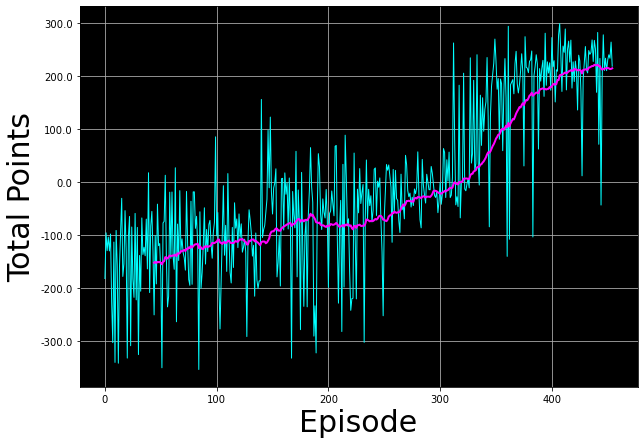

In [ ]:
# Plot the total point history along with the moving average.
utils_A1.plot_history(total_point_history)

## Visualizar el agente entrenado

La función `utils_A1.create_video` puede usarse para crear un video con la historia de nuestro agente interactuando con el entorno usando la red neuronal $Q$ entrenada. La función `utils_A1.create_video` utiliza la librería `imageio` para crear el video. Esta librería produce algunos avisos que pueden ser molestos, por lo que para suprimir estos avisos ejecutamos el siguiente código.


In [90]:
# Suppress warnings from imageio.
import logging
logging.getLogger().setLevel(logging.ERROR)

In [91]:
filename = "./videos/lunar_lander.mp4"

utils_A1.create_video(filename, env, q_network)
utils_A1.embed_mp4(filename)

ValueError: Could not find a backend to open `./videos/lunar_lander.mp4`` with iomode `w?`.
Based on the extension, the following plugins might add capable backends:
  FFMPEG:  pip install imageio[ffmpeg]
  pyav:  pip install imageio[pyav]